### import


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
from pprint import pprint
from PIL import Image

from google_play_scraper import reviews, Sort

from konlpy.tag import Okt
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from stopwords import get_stopwords  # 만약 오류 나면 직접 stopwords 리스트 사용

import warnings

warnings.filterwarnings("ignore")

### 데이터 수집


### 구글 playstore 리뷰 데이터


In [2]:
def gstore_reviews(app_id):
    # 리뷰 가져오기
    result = reviews(
        app_id,
        lang="en",  # 한국어 리뷰
        country="us",  # 한국
        sort=Sort.NEWEST,  # 최신 리뷰 먼저 가져오기
        count=100000,  # 가져올 리뷰 수 (최대 100000)
    )

    # 리뷰 데이터
    review_data = result[0]

    # DataFrame으로 변환
    return pd.DataFrame(review_data)

In [3]:
qz_df = gstore_reviews("com.quizlet.quizletandroid")
# qz_df.to_csv("/data/quizlet_rv.csv", index=False, encoding="utf-16")

In [4]:
qz_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92232 entries, 0 to 92231
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   reviewId              92232 non-null  object        
 1   userName              92232 non-null  object        
 2   userImage             92232 non-null  object        
 3   content               92193 non-null  object        
 4   score                 92232 non-null  int64         
 5   thumbsUpCount         92232 non-null  int64         
 6   reviewCreatedVersion  83051 non-null  object        
 7   at                    92232 non-null  datetime64[ns]
 8   replyContent          1398 non-null   object        
 9   repliedAt             1398 non-null   datetime64[ns]
 10  appVersion            83051 non-null  object        
dtypes: datetime64[ns](2), int64(2), object(7)
memory usage: 7.7+ MB


In [6]:
# 전체 리뷰 중 평점이 2점 이하인 부정 리뷰 추출
neg_reviews = qz_df[qz_df["score"] <= 2][["userName", "content", "score", "at"]]
# 날짜 컬럼을 datetime 형식으로 변환
neg_reviews["at"] = pd.to_datetime(neg_reviews["at"])

# 2023년 이후 데이터만 필터링
df_filtered = neg_reviews[neg_reviews["at"].dt.year >= 2023]
df_filtered[["content", "score", "at"]]
df_filtered.to_csv("./data/eng_neg_reviews.csv", index=False, encoding="utf-8-sig")
df_filtered

,userName,content,score,at
8,A Google user,We cannot customize font size of cards.,2,2025-02-28 09:49:04
10,A Google user,Why can't i just write my own without the AI c...,1,2025-02-28 04:30:15
12,A Google user,I am in 6 th class and this is not help ful,1,2025-02-28 02:32:47
18,A Google user,only showing me my starred flash cards in a se...,1,2025-02-28 00:27:45
21,A Google user,ITS VERY DIFFICULTY IN INTEGRATION CLASS 12¿¿,1,2025-02-28 00:18:23
...,...,...,...,...
14276,A Google user,Plz fix the bug which cause constant lost of a...,1,2023-01-02 21:15:07
14277,A Google user,The autofill option is being really buggy for ...,2,2023-01-02 20:23:49
14285,A Google user,You have to pay to use the flashcard testing f...,2,2023-01-02 07:14:52
14292,A Google user,Absolutely Brilliantly designed. Really helped...,2,2023-01-01 21:52:09


### 사용자 리뷰를 토대로 Quizlet의 학습용, 교구용 비율 분석


In [ ]:
# 학습용 분류 키워드 설정
study_keywords = [
    "exam",
    "vocabulary",
    "concept",
    "review",
    "memorization",
    "test",
    "learn",
    "study",
    "practice",
]
# 교구용 분류 키워드 설정
teaching_keywords = [
    "lesson",
    "quiz",
    "teacher",
    "worksheet",
    "student",
    "teachingl",
    "activity",
    "flashcard",
]


def categorize_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in study_keywords):
            return "학습용"
        elif any(word in text for word in teaching_keywords):
            return "교구용"
    return "기타"


# category 컬럼 추가, values = "학습용", "교구용", "기타"
qz_df["category"] = qz_df["content"].apply(categorize_content)

# 카테고리별 비율 계산
category_counts = qz_df["category"].value_counts(normalize=True) * 100
category_counts

category
기타     53.456841
학습용    41.663232
교구용     4.879927
Name: proportion, dtype: float64

### 유료 요금제 관련 리뷰 분석


In [ ]:
# 유료 요금 관련 리뷰 키워드 설정
plus_keywords = [
    "charged",
    "feed",
    "paid",
    "plus",
]


def paid_plan_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in plus_keywords):
            return True  # 키워드 포함된 경우, 원래 텍스트 반환
    return False  # 키워드 미포함 시 None 반환


# 필터링 된 리뷰만 저장
result_df = qz_df[qz_df["content"].apply(paid_plan_content)][
    ["userName", "content", "score", "at"]
].reset_index(drop=True)

# result_df.to_csv("/data/plus_rv.csv", index=False, encoding="utf-8")
result_df

,userName,content,score,at
0,A Google user,"I NEVER pay for apps, but i did purchase the u...",4,2025-02-23 14:10:22
1,A Google user,I love Quizlet. I wish you could use the learn...,5,2025-02-21 04:27:12
2,A Google user,Locking the test feature for Quizlet plus user...,1,2025-02-19 23:16:58
3,A Google user,It's just so good. I used it during my annual ...,5,2025-02-16 12:32:13
4,A Google user,I'm still in the free trial for the plus versi...,5,2025-02-16 05:17:53
...,...,...,...,...
1108,A Google user,Very helpful plus it's free. Win win,5,2014-10-06 04:47:30
1109,A Google user,"You can create cards on android now, but if yo...",2,2014-06-12 02:25:11
1110,A Google user,I love the simple/minimalist look of the appli...,4,2014-03-26 08:21:38
1111,A Google user,"1. Can't skip vocabulary (on a downloaded set,...",1,2013-11-05 15:28:37


### 문서 스캔 기능 관련 리뷰 분석


In [ ]:
scan_keywords = [
    "scan",
    "recogni",
    "OCR",
    "ocr",
]


def neg_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in scan_keywords):
            return "스캔"
    return "기타"


df_filtered["category"] = df_filtered["content"].apply(neg_content)

# 카테고리별 비율 계산
scan_ctg_cnt = df_filtered["category"].value_counts(normalize=True) * 100
scan_ctg_cnt

In [ ]:
def neg_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in scan_keywords):
            return False
    return True


filtered_neg_df = df_filtered[df_filtered["content"].apply(neg_content)][
    ["userName", "content", "score"]
].reset_index(drop=True)
filtered_neg_df

In [ ]:
def scan_content(text):
    if isinstance(text, str):  # 문자열인지 확인
        if any(word in text for word in scan_keywords):
            return True  # 키워드 포함된 경우 True 반환
    return False  # 키워드 미포함 시 False 반환


# 스캔 관련 리뷰 필터링
filtered_df = qz_df[qz_df["content"].apply(scan_content)][
    ["userName", "content", "score"]
].reset_index(drop=True)

# filtered_df.to_csv("/data/scan_rv.csv", index=False, encoding="utf-16")
filtered_df

,userName,content,score
0,A Google user,I saw dat cool scan and create into quiz optio...,1
1,A Google user,"has some best free features, only if it was ac...",4
2,A Google user,Hands down the best app for memorization. The ...,5
3,A Google user,it's so good manually to make flash cards but ...,4
4,A Google user,Creation of flash cards with OCR scanning save...,5
...,...,...,...
196,A Google user,I've only been using the app for the flashcard...,5
197,A Google user,Perfect for procrastinators like me. Also extr...,5
198,A Google user,Procrastination on my phone,5
199,A Google user,I love the simple/minimalist look of the appli...,4


### 워드클라우드 생성


In [ ]:
nltk.download("punkt")  # 토크나이저 다운로드


def get_WordCloud(df, title):
    stopwords = set(get_stopwords(language="en"))
    combined_text = " ".join(df["content"].astype(str))  # 모든 리뷰 합치기
    tokens = word_tokenize(combined_text.lower())  # 영어 단어 토큰화 및 소문자 변환
    filtered_tokens = [
        word for word in tokens if word.isalpha() and word not in stopwords
    ]
    word_freq = Counter(filtered_tokens)
    top_words = word_freq.most_common(80)  # 상위 80개 단어 추출
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color="black",
        colormap="Pastel1",
        max_words=80,
    ).generate_from_frequencies(dict(top_words))

    # 워드 클라우드 출력
    plt.figure(figsize=(10, 5))
    plt.title(title, fontsize=18, fontweight="bold")
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\blueb\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


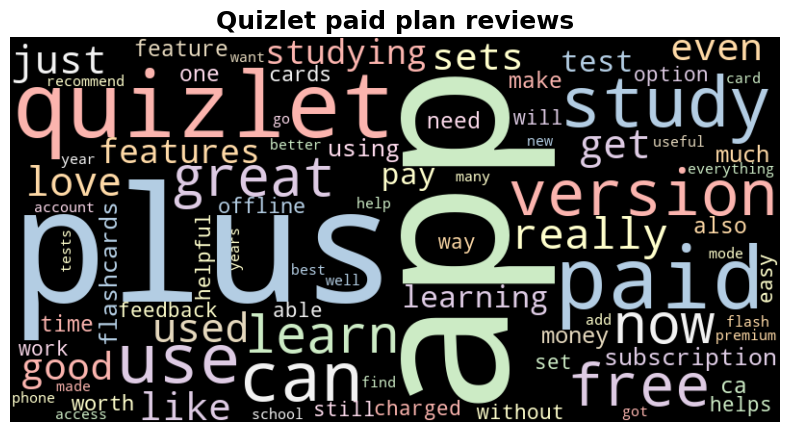

In [10]:
get_WordCloud(result_df, "Quizlet paid plan reviews")

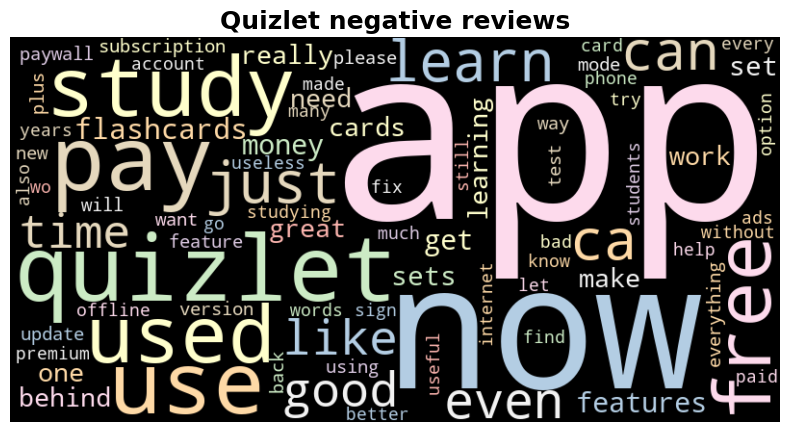

In [ ]:
get_WordCloud(qz_df[qz_df["score"] <= 2], "Quizlet negative reviews")

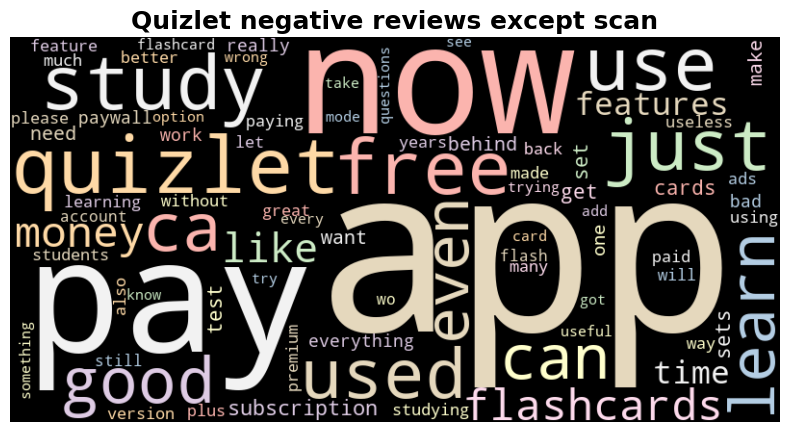

In [18]:
get_WordCloud(filtered_neg_df, "Quizlet negative reviews except scan")